#### `Import library`

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from unet import UNet
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Parameters
patch_size = 256
scaler = MinMaxScaler()

In [3]:
# Color to Class Mapping
def hex_to_rgb(hex_code):
    hex_code = hex_code.lstrip('#')
    return np.array(tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4)))

COLOR_MAP = {
    0: hex_to_rgb('#3C1098'),  # Building
    1: hex_to_rgb('#8429F6'),  # Land
    2: hex_to_rgb('#6EC1E4'),  # Road
    3: hex_to_rgb('FEDD3A'),   # Vegetation
    4: hex_to_rgb('E2A929'),   # Water
    5: hex_to_rgb('#9B9B9B')   # Unlabeled
}

def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape[:2], dtype=np.uint8)
    for k, v in COLOR_MAP.items():
        matches = np.all(label == v, axis=-1)
        label_seg[matches] = k
    return label_seg


In [4]:
# Custom Dataset class using CSV file
class SegmentationDataset(Dataset):
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file)
        self.image_patches = []
        self.mask_patches = []
        self._prepare_data()

    def _prepare_data(self):
        for idx, row in self.df.iterrows():
            img_path = row['Image']
            mask_path = row['Mask']

            # Load and crop image
            img = cv2.imread(img_path)
            h, w = img.shape[:2]
            img = Image.fromarray(img)
            img = img.crop((0, 0, (w // patch_size) * patch_size, (h // patch_size) * patch_size))
            img = np.array(img)
            img_patches = patchify(img, (patch_size, patch_size, 3), step=patch_size)

            # Load and crop mask
            mask = cv2.imread(mask_path)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask = Image.fromarray(mask)
            mask = mask.crop((0, 0, (w // patch_size) * patch_size, (h // patch_size) * patch_size))
            mask = np.array(mask)
            mask_patches = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

            for i in range(img_patches.shape[0]):
                for j in range(img_patches.shape[1]):
                    img_patch = img_patches[i, j, 0]
                    img_patch = scaler.fit_transform(img_patch.reshape(-1, 3)).reshape(img_patch.shape)
                    mask_patch = rgb_to_2D_label(mask_patches[i, j, 0])
                    self.image_patches.append(img_patch)
                    self.mask_patches.append(mask_patch)

    def __len__(self):
        return len(self.image_patches)
    
    def __getitem__(self, idx):
        image = torch.tensor(self.image_patches[idx], dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(self.mask_patches[idx], dtype=torch.long)
        return image, mask

# Detect device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: mps


In [5]:
# Load datasets
train_dataset = SegmentationDataset('train.csv')
test_dataset = SegmentationDataset('test.csv')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Number of classes
all_masks = np.concatenate([mask.numpy().flatten() for _, mask in train_dataset])
n_classes = len(np.unique(all_masks))

# Define model, loss, optimizer
model = UNet(n_classes=n_classes, in_channels=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [6]:
train_losses = []
test_losses = []

# Training loop
for epoch in range(1):
    model.train()
    total_train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation on test data
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Save model
torch.save(model.state_dict(), 'unet_model.pth')

Epoch 1, Train Loss: 1.7288, Test Loss: 1.3885


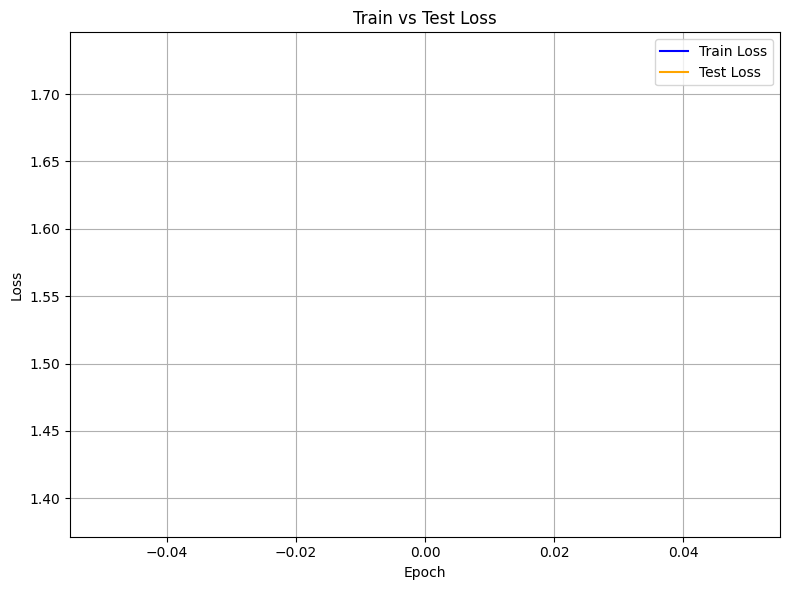

In [7]:
# Plot Train vs Test Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='orange')
plt.title("Train vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### `Class Activation Mapping (CAM): Better Interpretability in Deep Learning Models.`

In [8]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [9]:
#print(model)


Using device: mps


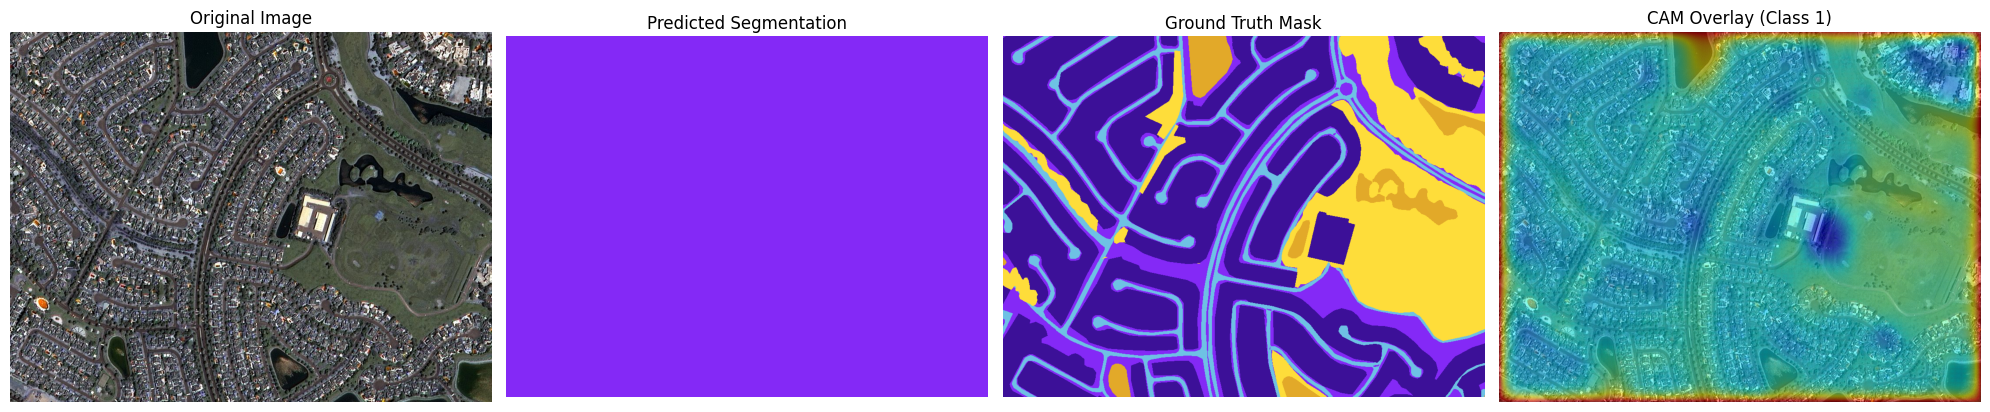

In [10]:
# --- Helper functions ---
def hex_to_rgb(hex_code):
    hex_code = hex_code.lstrip('#')
    return np.array(tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4)))

COLOR_MAP = {
    0: hex_to_rgb('#3C1098'),  # Building
    1: hex_to_rgb('#8429F6'),  # Land
    2: hex_to_rgb('#6EC1E4'),  # Road
    3: hex_to_rgb('FEDD3A'),   # Vegetation
    4: hex_to_rgb('E2A929'),   # Water
    5: hex_to_rgb('#9B9B9B')   # Unlabeled
}

def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape[:2], dtype=np.uint8)
    for k, v in COLOR_MAP.items():
        matches = np.all(label == v, axis=-1)
        label_seg[matches] = k
    return label_seg

def label_to_rgb(label_2d):
    rgb_img = np.zeros((label_2d.shape[0], label_2d.shape[1], 3), dtype=np.uint8)
    for k, v in COLOR_MAP.items():
        rgb_img[label_2d == k] = v
    return rgb_img

# --- Device setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Load model ---
model = UNet(n_classes=6, in_channels=3).to(device)
model.load_state_dict(torch.load('unet_model.pth', map_location=device))
model.eval()

# --- Register CAM hook on the last conv in c9 ---
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.c9.double_conv[3].register_forward_hook(get_activation('final_conv'))

# --- Load image and mask from CSV ---
val_df = pd.read_csv('val.csv')
image_path = val_df.iloc[1]['Image']
mask_path = val_df.iloc[1]['Mask']

# --- Load and process image ---
patch_size = 256
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_crop = Image.fromarray(img_rgb).crop(
    (0, 0, (img.shape[1] // patch_size) * patch_size, (img.shape[0] // patch_size) * patch_size)
)
img_np = np.array(img_crop)

img_norm = img_np / 255.0
img_tensor = torch.tensor(img_norm, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

# --- Inference ---
with torch.no_grad():
    output = model(img_tensor)
    predicted_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

# --- Load and process ground truth mask ---
gt_mask = cv2.imread(mask_path)
gt_mask = cv2.cvtColor(gt_mask, cv2.COLOR_BGR2RGB)
gt_crop = Image.fromarray(gt_mask).crop(
    (0, 0, (gt_mask.shape[1] // patch_size) * patch_size, (gt_mask.shape[0] // patch_size) * patch_size)
)
gt_mask_np = np.array(gt_crop)
gt_label = rgb_to_2D_label(gt_mask_np)

# --- CAM generation ---
class_idx = 1  # Change to visualize other classes (0 to 5)

feature_maps = activation['final_conv']  # shape: [1, 16, H, W]
weights = model.out.weight[class_idx].squeeze()  # shape: [16]

cam = torch.einsum('bchw,c->bhw', feature_maps, weights)
cam = cam.squeeze().detach().cpu().numpy()
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)

# Resize CAM to input image size
cam_resized = cv2.resize(cam, (img_rgb.shape[1], img_rgb.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
img_float = img_rgb.astype(np.float32) / 255
overlayed = heatmap + img_float
overlayed = overlayed / np.max(overlayed)

# --- Convert prediction and GT masks to RGB ---
pred_rgb = label_to_rgb(predicted_mask)
gt_rgb = label_to_rgb(gt_label)

# --- Plot everything ---
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(pred_rgb)
plt.title("Predicted Segmentation")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(gt_rgb)
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(overlayed)
plt.title(f"CAM Overlay (Class {class_idx})")
plt.axis('off')

plt.tight_layout()
plt.show()


In [11]:
#### `Prediction`

Using device: mps


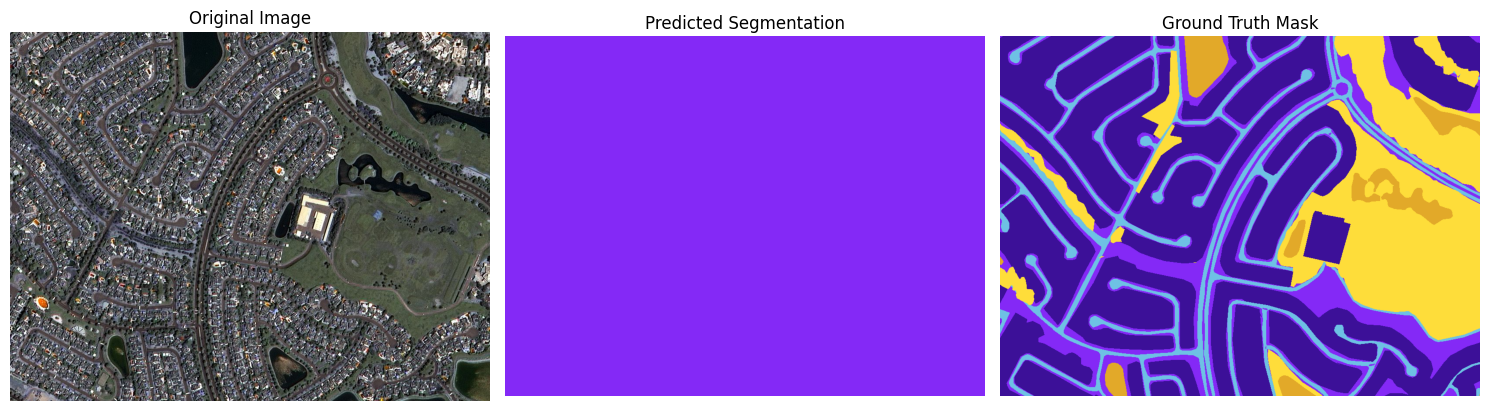

In [12]:
# --- Load helper functions and color map ---
def hex_to_rgb(hex_code):
    hex_code = hex_code.lstrip('#')
    return np.array(tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4)))

COLOR_MAP = {
    0: hex_to_rgb('#3C1098'),  # Building
    1: hex_to_rgb('#8429F6'),  # Land
    2: hex_to_rgb('#6EC1E4'),  # Road
    3: hex_to_rgb('FEDD3A'),   # Vegetation
    4: hex_to_rgb('E2A929'),   # Water
    5: hex_to_rgb('#9B9B9B')   # Unlabeled
}

def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape[:2], dtype=np.uint8)
    for k, v in COLOR_MAP.items():
        matches = np.all(label == v, axis=-1)
        label_seg[matches] = k
    return label_seg

def label_to_rgb(label_2d):
    rgb_img = np.zeros((label_2d.shape[0], label_2d.shape[1], 3), dtype=np.uint8)
    for k, v in COLOR_MAP.items():
        rgb_img[label_2d == k] = v
    return rgb_img

# --- Define device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Load model ---
model = UNet(n_classes=6, in_channels=3).to(device)  # Make sure UNet class is defined
model.load_state_dict(torch.load('unet_model.pth', map_location=device))
model.eval()

# --- Load first image and mask from val.csv ---
val_df = pd.read_csv('val.csv')
image_path = val_df.iloc[1]['Image']
mask_path = val_df.iloc[1]['Mask']

# --- Load image ---
patch_size = 256
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_crop = Image.fromarray(img_rgb).crop((0, 0, (img.shape[1] // patch_size) * patch_size, (img.shape[0] // patch_size) * patch_size))
img_np = np.array(img_crop)

# Normalize
img_norm = img_np / 255.0
img_tensor = torch.tensor(img_norm, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

# --- Inference ---
with torch.no_grad():
    output = model(img_tensor)
    predicted_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

# --- Load ground truth mask ---
gt_mask = cv2.imread(mask_path)
gt_mask = cv2.cvtColor(gt_mask, cv2.COLOR_BGR2RGB)
gt_crop = Image.fromarray(gt_mask).crop((0, 0, (gt_mask.shape[1] // patch_size) * patch_size, (gt_mask.shape[0] // patch_size) * patch_size))
gt_mask_np = np.array(gt_crop)
gt_label = rgb_to_2D_label(gt_mask_np)

# --- Convert masks to RGB for plotting ---
pred_rgb = label_to_rgb(predicted_mask)
gt_rgb = label_to_rgb(gt_label)

# --- Plot ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(pred_rgb)
plt.title("Predicted Segmentation")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(gt_rgb)
plt.title("Ground Truth Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


#### `Version`

In [13]:
import os
import cv2
import numpy as np
import matplotlib
import torch
import sklearn
import pandas as pd
from patchify import patchify
from PIL import Image
import torchvision

# Collect package versions
packages = {
    "os": "builtin",
    "cv2": cv2.__version__,
    "numpy": np.__version__,
    "matplotlib": matplotlib.__version__,
    "patchify": patchify.__module__.split('.')[0],  # only to confirm it's imported
    "Pillow": Image.__version__,
    "scikit-learn": sklearn.__version__,
    "pandas": pd.__version__,
    "torch": torch.__version__,
    "torchvision": torchvision.__version__,
    "unet": "local"  # Assuming UNet is from your local unet.py file
}

# Print versions
print("Package versions used in this environment:")
for pkg, ver in packages.items():
    print(f"{pkg}=={ver}")

# Save to requirements.txt (excluding builtin and local packages)
with open("requirements.txt", "w") as f:
    for pkg, ver in packages.items():
        if ver not in ("builtin", "local"):
            # Handle Pillow separately because it's imported as PIL
            if pkg == "Pillow":
                f.write(f"Pillow=={ver}\n")
            else:
                f.write(f"{pkg}=={ver}\n")

print("\nSaved versions to requirements.txt")


Package versions used in this environment:
os==builtin
cv2==4.12.0
numpy==1.26.4
matplotlib==3.10.3
patchify==patchify
Pillow==11.3.0
scikit-learn==1.7.0
pandas==2.3.1
torch==2.7.1
torchvision==0.22.1
unet==local

Saved versions to requirements.txt
